**This notebook is to train and test the CNN-driven advection scheme.**

This notebook perform loading the velocity field, implementing the machine-learned scheme, training the scheme, wallclock time measurement, and visualization.

In [1]:
## Import packages ##

#import Pkg
#Pkg.add("Plots")
using Plots
#Pkg.add("BenchmarkTools")
using BenchmarkTools
#Pkg.add("Flux")
using Flux
#Pkg.add("CSV")
using CSV
#Pkg.add("DelimitedFiles")
using DelimitedFiles
#Pkg.add("Statistics")
using Statistics
#Pkg.add("BSON")
using BSON: @save
using BSON: @load
#Pkg.add("Random")
using Random
#Pkg.add("CUDA")
using CUDA

In [2]:
# When we trained the model with a single dataset, we used this code.
vel1_GEOS_Array = readdlm( "Training_dataset/Vel_GEOS_Jan_2019_NASA_GMAO_10_U_1x_4x.csv", ',', Float32);
scalar1_GEOS_Array = readdlm("Training_dataset/VL_GEOS_Jan_2019_NASA_GMAO_10_U_1x_4x.csv", ',', Float32);

xdim = size(vel1_GEOS_Array, 1);
nstep = size(vel1_GEOS_Array, 2);

In [3]:
# Sometimes, we wanted to check the maximum CFL number in the velocity field we used.
maximum(vel1_GEOS_Array*300/27034.3)

0.22384399893145004

In [2]:
## For training with the multiple datasets, we used this code.
## For 2-D demonstration, we trained the solver for (16dx, 64dt) resolution again with 7 different datasets, 
## including the orignial trainign dataset and the generalization testing sets.

vel1_GEOS_Array = readdlm( "Training_dataset/Vel_GEOS_Jan_2019_NASA_GMAO_10_U_16x_64x.csv", ',', Float32);
scalar1_GEOS_Array = readdlm("Training_dataset/VL_GEOS_Jan_2019_NASA_GMAO_10_U_16x_64x.csv", ',', Float32);
vel2_GEOS_Array = readdlm("Generalization_tests/Season_April/Vel_GEOS_Jan_2019_NASA_GMAO_10_U_16x_64x.csv", ',', Float32);
scalar2_GEOS_Array = readdlm("Generalization_tests/Season_April/VL_GEOS_Jan_2019_NASA_GMAO_10_U_16x_64x.csv", ',', Float32);
vel3_GEOS_Array = readdlm("Generalization_tests/Season_Jul/Vel_GEOS_Jan_2019_NASA_GMAO_10_U_16x_64x.csv", ',', Float32);
scalar3_GEOS_Array = readdlm("Generalization_tests/Season_Jul/VL_GEOS_Jan_2019_NASA_GMAO_10_U_16x_64x.csv", ',', Float32);
vel4_GEOS_Array = readdlm("Generalization_tests/Season_Oct/Vel_GEOS_Jan_2019_NASA_GMAO_10_U_16x_64x.csv", ',', Float32);
scalar4_GEOS_Array = readdlm("Generalization_tests/Season_Oct/VL_GEOS_Jan_2019_NASA_GMAO_10_U_16x_64x.csv", ',', Float32);
vel5_GEOS_Array = readdlm("Generalization_tests/Lat_29N_corrected/Vel_GEOS_Jan_2019_NASA_GMAO_10_U_16x_64x.csv", ',', Float32);
scalar5_GEOS_Array = readdlm("Generalization_tests/Lat_29N_corrected/VL_GEOS_Jan_2019_NASA_GMAO_10_U_16x_64x.csv", ',', Float32);
vel6_GEOS_Array = readdlm("Generalization_tests/Lat_45N_corrected/Vel_GEOS_Jan_2019_NASA_GMAO_10_U_16x_64x.csv", ',', Float32);
scalar6_GEOS_Array = readdlm("Generalization_tests/Lat_45N_corrected/VL_GEOS_Jan_2019_NASA_GMAO_10_U_16x_64x.csv", ',', Float32);
vel7_GEOS_Array = readdlm("Generalization_tests/Longitudinal/Vel_GEOS_Jan_2019_NASA_GMAO_10_U_16x_64x.csv", ',', Float32);
scalar7_GEOS_Array = readdlm("Generalization_tests/Longitudinal/VL_GEOS_Jan_2019_NASA_GMAO_10_U_16x_64x.csv", ',', Float32);
xdim = size(vel1_GEOS_Array, 1);
ydim = size(vel7_GEOS_Array, 1);
nstep = size(vel1_GEOS_Array, 2);

In [3]:
# Add noise and normalize the input scale.

Random.seed!(1)
history = (scalar1_GEOS_Array*Float32(1e7), vel1_GEOS_Array/15);
#history = (scalar1_GEOS_Array*Float32(1e7) + 4e-5*rand(Float32, xdim, nstep), vel1_GEOS_Array/15);
#history2 = (scalar2_GEOS_Array*Float32(1e7) + 4e-5*rand(Float32, xdim, nstep), vel2_GEOS_Array/15);
#history3 = (scalar3_GEOS_Array*Float32(1e7) + 4e-5*rand(Float32, xdim, nstep), vel3_GEOS_Array/15);
#history4 = (scalar4_GEOS_Array*Float32(1e7) + 4e-5*rand(Float32, xdim, nstep), vel4_GEOS_Array/15);
#history5 = (scalar5_GEOS_Array*Float32(1e7) + 4e-5*rand(Float32, xdim, nstep), vel5_GEOS_Array/15);
#history6 = (scalar6_GEOS_Array*Float32(1e7) + 4e-5*rand(Float32, xdim, nstep), vel6_GEOS_Array/15);
#history7 = (scalar7_GEOS_Array*Float32(1e7) + 4e-5*rand(Float32, ydim, nstep), vel7_GEOS_Array/15);

Depending on the resolutions, we could use the solver code with different kernel sizes. pgm_ml() is the code to integrate throughout the whole timesteps, while one_step_integrate() is the code for a single step integration, which is used in model training.

In [5]:
## Integrating through the whole timesteps using ML based advection solver ##
## Programming advection scheme with 3 stencil (default) ##

function pgm_ml(x, u1, model, xdim_total, nstep_total, dx, dt)
    
    ## Initialize
    history_2x_learned = zeros(Float32, xdim_total, 1, nstep)
    history_2x_learned[:,:,1] = x[:,1,1,1]
    s1_input = x[:,:,:,1]
    #s1_scale = s1_input
    s1_bc = zeros(xdim_total+2)
    
    ## Integrate
    for n in 1:nstep_total-1
        # learned solver
        #coeff_estimated = model(hcat(s1_input, u1[:,:,:,n]))
        coeff_estimated = reshape(model(hcat(s1_input, u1[:,:,:,n])), (xdim_total, 2, 3))
        su = s1_input
        s1_bc = vcat( [su[1]], [su[i] for i in 1:xdim_total], [su[xdim_total]])
        s1_scale = reshape(hcat([s1_bc[i] for i in 1:xdim_total],
                [s1_bc[i] for i in 2:xdim_total+1],
                [s1_bc[i] for i in 3:xdim_total+2]), xdim_total, 3)
        s2_2x = reshape(s1_input, xdim_total) + 100*dt/dx*sum(coeff_estimated[:,1,:].*s1_scale, dims=2) 
                + 10000*(dt*dt)/(dx*dx)*sum(coeff_estimated[:,2,:].*s1_scale, dims=2)
        
        history_2x_learned[:,1,n+1] = s2_2x
        s1_input = reshape(s2_2x, (xdim_total,1,1))
    end
    
    return history_2x_learned
end

pgm_ml (generic function with 1 method)

In [4]:
## Integrating a single timestep using ML based advection solver ##
## This code is called for model training later ##
## Integrate function with 3 stencil (default) ##

function one_step_integrate(x, u1, model, xdim_total, dx, dt)
    ## Initialize
    s1_input = reshape(x, (xdim_total, 1, 1))
    #s1_scale = s1_input
    
    # learned solver
    coeff_estimated = reshape(model(hcat(s1_input, u1)), (xdim_total, 2, 3))
    su = s1_input
    s1_bc = vcat( [su[1]], [su[i] for i in 1:xdim_total], [su[xdim_total]])
    s1_scale = reshape(hcat([s1_bc[i] for i in 1:xdim_total],
                [s1_bc[i] for i in 2:xdim_total+1],
                [s1_bc[i] for i in 3:xdim_total+2]), xdim_total, 3)
    s2_2x = reshape(s1_input, xdim_total) + 100*dt/dx*sum(coeff_estimated[:,1,:].*s1_scale, dims=2) 
                + 10000*(dt*dt)/(dx*dx)*sum(coeff_estimated[:,2,:].*s1_scale, dims=2)
    
    s1_input = reshape(s2_2x, (xdim_total,1,1))
    return s2_2x
end

one_step_integrate (generic function with 1 method)

In [5]:
## Integrating through the whole timesteps using ML based advection solver ##
## Programming advection scheme with 5 stencil ##

function pgm_ml(x, u1, model, xdim_total, nstep_total, dx, dt)
    
    ## Initialize
    history_2x_learned = zeros(Float32, xdim, 1, nstep)
    history_2x_learned[:,:,1] = x[:,1,1,1]
    s1_input = x[:,:,:,1]
    #s1_scale = s1_input
    s1_bc = zeros(xdim_total+4)
    
    ## Integrate
    for n in 1:nstep_total-1
        # learned solver
        #coeff_estimated = model(hcat(s1_input, u1[:,:,:,n]))
        coeff_estimated = reshape(model(hcat(s1_input, u1[:,:,:,n])), (xdim_total, 2, 5))
        su = s1_input
        s1_bc = vcat( [su[1]], [su[1]], [su[i] for i in 1:xdim_total], [su[xdim_total]], [su[xdim_total]])
        s1_scale = reshape(hcat([s1_bc[i] for i in 1:xdim_total],
                [s1_bc[i] for i in 2:xdim_total+1],
                [s1_bc[i] for i in 3:xdim_total+2],
                [s1_bc[i] for i in 4:xdim_total+3],
                [s1_bc[i] for i in 5:xdim_total+4]), xdim_total, 5)
        s2_2x = reshape(s1_input, xdim_total) + 100*dt/dx*sum(coeff_estimated[:,1,:].*s1_scale, dims=2) 
                + 10000*(dt*dt)/(dx*dx)*sum(coeff_estimated[:,2,:].*s1_scale, dims=2)
        
        history_2x_learned[:,1,n+1] = s2_2x
        s1_input = reshape(s2_2x, (xdim_total,1,1))
    end
    
    return history_2x_learned
end

pgm_ml (generic function with 1 method)

In [6]:
## Integrating a single timestep using ML based advection solver ##
## This code is called for model training later ##
## Integrate function with 5 stencil ##

function one_step_integrate(x, u1, model, xdim_total, dx, dt)
    ## Initialize
    s1_input = reshape(x, (xdim, 1, 1))
    #s1_scale = s1_input
    
    # learned solver
    coeff_estimated = reshape(model(hcat(s1_input, u1)), (xdim_total, 2, 5))
    su = s1_input
    s1_bc = vcat( [su[1]], [su[1]], [su[i] for i in 1:xdim_total], [su[xdim_total]], [su[xdim_total]])
    s1_scale = reshape(hcat([s1_bc[i] for i in 1:xdim_total],
                [s1_bc[i] for i in 2:xdim_total+1],
                [s1_bc[i] for i in 3:xdim_total+2],
                [s1_bc[i] for i in 4:xdim_total+3],
                [s1_bc[i] for i in 5:xdim_total+4]), xdim_total, 5)
    s2_2x = reshape(s1_input, xdim_total) + 100*dt/dx*sum(coeff_estimated[:,1,:].*s1_scale, dims=2) 
                + 10000*(dt*dt)/(dx*dx)*sum(coeff_estimated[:,2,:].*s1_scale, dims=2)
    
    s1_input = reshape(s2_2x, (xdim_total,1,1))
    return s2_2x
end

one_step_integrate (generic function with 1 method)

In [4]:
## Integrating through the whole timesteps using ML based advection solver ##
## Programming advection scheme with 9 stencil ##

function pgm_ml(x, u1, model, xdim_total, nstep_total, dx, dt)
    
    ## Initialize
    history_2x_learned = zeros(Float32, xdim, 1, nstep)
    history_2x_learned[:,:,1] = x[:,1,1,1]
    s1_input = x[:,:,:,1]
    #s1_scale = s1_input
    #s1_bc = zeros(xdim_total+4)
    
    ## Integrate
    for n in 1:nstep_total-1
        # learned solver
        #coeff_estimated = model(hcat(s1_input, u1[:,:,:,n]))
        coeff_estimated = reshape(model(hcat(s1_input, u1[:,:,:,n])), (xdim_total, 2, 9))
        su = s1_input
        s1_bc = vcat( [su[1]], [su[1]], [su[1]], [su[1]], [su[i] for i in 1:xdim_total], 
            [su[xdim_total]], [su[xdim_total]], [su[xdim_total]], [su[xdim_total]])
        s1_scale = reshape(hcat([s1_bc[i] for i in 1:xdim_total],
                [s1_bc[i] for i in 2:xdim_total+1],
                [s1_bc[i] for i in 3:xdim_total+2],
                [s1_bc[i] for i in 4:xdim_total+3],
                [s1_bc[i] for i in 5:xdim_total+4],
                [s1_bc[i] for i in 6:xdim_total+5],
                [s1_bc[i] for i in 7:xdim_total+6],
                [s1_bc[i] for i in 8:xdim_total+7],
                [s1_bc[i] for i in 9:xdim_total+8]), xdim_total, 9)
        s2_2x = reshape(s1_input, xdim_total) + 100*dt/dx*sum(coeff_estimated[:,1,:].*s1_scale, dims=2) 
                + 10000*(dt*dt)/(dx*dx)*sum(coeff_estimated[:,2,:].*s1_scale, dims=2)
        
        history_2x_learned[:,1,n+1] = s2_2x
        s1_input = reshape(s2_2x, (xdim_total,1,1))
    end
    
    return history_2x_learned
end

pgm_ml (generic function with 1 method)

In [5]:
## Integrating a single timestep using ML based advection solver ##
## This code is called for model training later ##
## Integrate function with 9 stencil ##

function one_step_integrate(x, u1, model, xdim_total, dx, dt)
    ## Initialize
    s1_input = reshape(x, (xdim, 1, 1))
    #s1_scale = s1_input
    
    # learned solver
    coeff_estimated = reshape(model(hcat(s1_input, u1)), (xdim_total, 2, 9))
    su = s1_input
    s1_bc = vcat( [su[1]], [su[1]], [su[1]], [su[1]], [su[i] for i in 1:xdim_total], 
            [su[xdim_total]], [su[xdim_total]], [su[xdim_total]], [su[xdim_total]])
    s1_scale = reshape(hcat([s1_bc[i] for i in 1:xdim_total],
                [s1_bc[i] for i in 2:xdim_total+1],
                [s1_bc[i] for i in 3:xdim_total+2],
                [s1_bc[i] for i in 4:xdim_total+3],
                [s1_bc[i] for i in 5:xdim_total+4],
                [s1_bc[i] for i in 6:xdim_total+5],
                [s1_bc[i] for i in 7:xdim_total+6],
                [s1_bc[i] for i in 8:xdim_total+7],
                [s1_bc[i] for i in 9:xdim_total+8]), xdim_total, 9)
    s2_2x = reshape(s1_input, xdim_total) + 100*dt/dx*sum(coeff_estimated[:,1,:].*s1_scale, dims=2) 
                + 10000*(dt*dt)/(dx*dx)*sum(coeff_estimated[:,2,:].*s1_scale, dims=2)
    
    s1_input = reshape(s2_2x, (xdim_total,1,1))
    return s2_2x
end

one_step_integrate (generic function with 1 method)

In [5]:
## Integrating through the whole timesteps using ML based advection solver ##
## Programming advection scheme with 17 stencil ##

function pgm_ml(x, u1, model, xdim_total, nstep_total, dx, dt)
    
    ## Initialize
    history_2x_learned = zeros(Float32, xdim, 1, nstep)
    history_2x_learned[:,:,1] = x[:,1,1,1]
    s1_input = x[:,:,:,1]
    #s1_scale = s1_input
    #s1_bc = zeros(xdim_total+4)
    
    ## Integrate
    for n in 1:nstep_total-1
        # learned solver
        #coeff_estimated = model(hcat(s1_input, u1[:,:,:,n]))
        coeff_estimated = reshape(model(hcat(s1_input, u1[:,:,:,n])), (xdim_total, 2, 17))
        su = s1_input
        s1_bc = vcat( [su[1]], [su[1]], [su[1]], [su[1]], [su[1]], [su[1]], [su[1]], [su[1]], [su[i] for i in 1:xdim_total], 
            [su[xdim_total]], [su[xdim_total]], [su[xdim_total]], [su[xdim_total]], 
            [su[xdim_total]], [su[xdim_total]], [su[xdim_total]], [su[xdim_total]])
        s1_scale = reshape(hcat([s1_bc[i] for i in 1:xdim_total],
                [s1_bc[i] for i in 2:xdim_total+1],
                [s1_bc[i] for i in 3:xdim_total+2],
                [s1_bc[i] for i in 4:xdim_total+3],
                [s1_bc[i] for i in 5:xdim_total+4],
                [s1_bc[i] for i in 6:xdim_total+5],
                [s1_bc[i] for i in 7:xdim_total+6],
                [s1_bc[i] for i in 8:xdim_total+7],
                [s1_bc[i] for i in 9:xdim_total+8],
                [s1_bc[i] for i in 10:xdim_total+9],
                [s1_bc[i] for i in 11:xdim_total+10],
                [s1_bc[i] for i in 12:xdim_total+11],
                [s1_bc[i] for i in 13:xdim_total+12],
                [s1_bc[i] for i in 14:xdim_total+13],
                [s1_bc[i] for i in 15:xdim_total+14],
                [s1_bc[i] for i in 16:xdim_total+15],
                [s1_bc[i] for i in 17:xdim_total+16]), xdim_total, 17)
        s2_2x = reshape(s1_input, xdim_total) + 100*dt/dx*sum(coeff_estimated[:,1,:].*s1_scale, dims=2) 
                + 10000*(dt*dt)/(dx*dx)*sum(coeff_estimated[:,2,:].*s1_scale, dims=2)
        
        history_2x_learned[:,1,n+1] = s2_2x
        s1_input = reshape(s2_2x, (xdim_total,1,1))
    end
    
    return history_2x_learned
end

pgm_ml (generic function with 1 method)

In [6]:
## Integrating a single timestep using ML based advection solver ##
## This code is called for model training later ##
## Integrate function with 17 stencil ##

function one_step_integrate(x, u1, model, xdim_total, dx, dt)
    ## Initialize
    s1_input = reshape(x, (xdim, 1, 1))
    #s1_scale = s1_input
    
    # learned solver
    coeff_estimated = reshape(model(hcat(s1_input, u1)), (xdim_total, 2, 17))
    su = s1_input
    s1_bc = vcat( [su[1]], [su[1]], [su[1]], [su[1]], [su[1]], [su[1]], [su[1]], [su[1]], [su[i] for i in 1:xdim_total], 
            [su[xdim_total]], [su[xdim_total]], [su[xdim_total]], [su[xdim_total]], 
            [su[xdim_total]], [su[xdim_total]], [su[xdim_total]], [su[xdim_total]])
        s1_scale = reshape(hcat([s1_bc[i] for i in 1:xdim_total],
                [s1_bc[i] for i in 2:xdim_total+1],
                [s1_bc[i] for i in 3:xdim_total+2],
                [s1_bc[i] for i in 4:xdim_total+3],
                [s1_bc[i] for i in 5:xdim_total+4],
                [s1_bc[i] for i in 6:xdim_total+5],
                [s1_bc[i] for i in 7:xdim_total+6],
                [s1_bc[i] for i in 8:xdim_total+7],
                [s1_bc[i] for i in 9:xdim_total+8],
                [s1_bc[i] for i in 10:xdim_total+9],
                [s1_bc[i] for i in 11:xdim_total+10],
                [s1_bc[i] for i in 12:xdim_total+11],
                [s1_bc[i] for i in 13:xdim_total+12],
                [s1_bc[i] for i in 14:xdim_total+13],
                [s1_bc[i] for i in 15:xdim_total+14],
                [s1_bc[i] for i in 16:xdim_total+15],
                [s1_bc[i] for i in 17:xdim_total+16]), xdim_total, 17)
    s2_2x = reshape(s1_input, xdim_total) + 100*dt/dx*sum(coeff_estimated[:,1,:].*s1_scale, dims=2) 
                + 10000*(dt*dt)/(dx*dx)*sum(coeff_estimated[:,2,:].*s1_scale, dims=2)
    
    s1_input = reshape(s2_2x, (xdim_total,1,1))
    return s2_2x
end

one_step_integrate (generic function with 1 method)

In [4]:
## Integrating through the whole timesteps using ML based advection solver ##
## Programming advection scheme with 31 stencil ##

function pgm_ml(x, u1, model, xdim_total, nstep_total, dx, dt)
    
    ## Initialize
    history_2x_learned = zeros(Float32, xdim, 1, nstep)
    history_2x_learned[:,:,1] = x[:,1,1,1]
    s1_input = x[:,:,:,1]
    #s1_scale = s1_input
    #s1_bc = zeros(xdim_total+4)
    
    ## Integrate
    for n in 1:nstep_total-1
        # learned solver
        #coeff_estimated = model(hcat(s1_input, u1[:,:,:,n]))
        coeff_estimated = reshape(model(hcat(s1_input, u1[:,:,:,n])), (xdim_total, 2, 31))
        su = s1_input
        s1_bc = vcat( [su[1]], [su[1]], [su[1]], [su[1]], [su[1]], [su[1]], [su[1]], [su[1]], [su[1]], [su[1]], 
                [su[1]], [su[1]], [su[1]], [su[1]], [su[1]], [su[i] for i in 1:xdim_total], 
                [su[xdim_total]], [su[xdim_total]], [su[xdim_total]], [su[xdim_total]], [su[xdim_total]], [su[xdim_total]],
                [su[xdim_total]], [su[xdim_total]], [su[xdim_total]], [su[xdim_total]], [su[xdim_total]], [su[xdim_total]],
                [su[xdim_total]], [su[xdim_total]], [su[xdim_total]])
        s1_scale = reshape(hcat([s1_bc[i] for i in 1:xdim_total],
                [s1_bc[i] for i in 2:xdim_total+1],
                [s1_bc[i] for i in 3:xdim_total+2],
                [s1_bc[i] for i in 4:xdim_total+3],
                [s1_bc[i] for i in 5:xdim_total+4],
                [s1_bc[i] for i in 6:xdim_total+5],
                [s1_bc[i] for i in 7:xdim_total+6],
                [s1_bc[i] for i in 8:xdim_total+7],
                [s1_bc[i] for i in 9:xdim_total+8],
                [s1_bc[i] for i in 10:xdim_total+9],
                [s1_bc[i] for i in 11:xdim_total+10],
                [s1_bc[i] for i in 12:xdim_total+11],
                [s1_bc[i] for i in 13:xdim_total+12],
                [s1_bc[i] for i in 14:xdim_total+13],
                [s1_bc[i] for i in 15:xdim_total+14],
                [s1_bc[i] for i in 16:xdim_total+15],
                [s1_bc[i] for i in 17:xdim_total+16],
                [s1_bc[i] for i in 18:xdim_total+17],
                [s1_bc[i] for i in 19:xdim_total+18],
                [s1_bc[i] for i in 20:xdim_total+19],
                [s1_bc[i] for i in 21:xdim_total+20],
                [s1_bc[i] for i in 22:xdim_total+21],
                [s1_bc[i] for i in 23:xdim_total+22],
                [s1_bc[i] for i in 24:xdim_total+23],
                [s1_bc[i] for i in 25:xdim_total+24],
                [s1_bc[i] for i in 26:xdim_total+25],
                [s1_bc[i] for i in 27:xdim_total+26],
                [s1_bc[i] for i in 28:xdim_total+27],
                [s1_bc[i] for i in 29:xdim_total+28],
                [s1_bc[i] for i in 30:xdim_total+29],
                [s1_bc[i] for i in 31:xdim_total+30]), xdim_total, 31)
        s2_2x = reshape(s1_input, xdim_total) + 100*dt/dx*sum(coeff_estimated[:,1,:].*s1_scale, dims=2) 
                + 10000*(dt*dt)/(dx*dx)*sum(coeff_estimated[:,2,:].*s1_scale, dims=2)
        
        history_2x_learned[:,1,n+1] = s2_2x
        s1_input = reshape(s2_2x, (xdim_total,1,1))
    end
    
    return history_2x_learned
end

pgm_ml (generic function with 1 method)

In [5]:
## Integrating a single timestep using ML based advection solver ##
## This code is called for model training later ##
## Integrate function with 31 stencil ##

function one_step_integrate(x, u1, model, xdim_total, dx, dt)
    ## Initialize
    s1_input = reshape(x, (xdim, 1, 1))
    #s1_scale = s1_input
    
    # learned solver
    coeff_estimated = reshape(model(hcat(s1_input, u1)), (xdim_total, 2, 31))
    su = s1_input
    s1_bc = vcat( [su[1]], [su[1]], [su[1]], [su[1]], [su[1]], [su[1]],
                [su[1]], [su[1]], [su[1]], [su[1]], [su[1]], [su[1]],
                [su[1]], [su[1]], [su[1]], [su[i] for i in 1:xdim_total], 
                [su[xdim_total]], [su[xdim_total]], [su[xdim_total]], [su[xdim_total]], [su[xdim_total]], [su[xdim_total]],
                [su[xdim_total]], [su[xdim_total]], [su[xdim_total]], [su[xdim_total]], [su[xdim_total]], [su[xdim_total]],
                [su[xdim_total]], [su[xdim_total]], [su[xdim_total]])
    s1_scale = reshape(hcat([s1_bc[i] for i in 1:xdim_total],
                [s1_bc[i] for i in 2:xdim_total+1],
                [s1_bc[i] for i in 3:xdim_total+2],
                [s1_bc[i] for i in 4:xdim_total+3],
                [s1_bc[i] for i in 5:xdim_total+4],
                [s1_bc[i] for i in 6:xdim_total+5],
                [s1_bc[i] for i in 7:xdim_total+6],
                [s1_bc[i] for i in 8:xdim_total+7],
                [s1_bc[i] for i in 9:xdim_total+8],
                [s1_bc[i] for i in 10:xdim_total+9],
                [s1_bc[i] for i in 11:xdim_total+10],
                [s1_bc[i] for i in 12:xdim_total+11],
                [s1_bc[i] for i in 13:xdim_total+12],
                [s1_bc[i] for i in 14:xdim_total+13],
                [s1_bc[i] for i in 15:xdim_total+14],
                [s1_bc[i] for i in 16:xdim_total+15],
                [s1_bc[i] for i in 17:xdim_total+16],
                [s1_bc[i] for i in 18:xdim_total+17],
                [s1_bc[i] for i in 19:xdim_total+18],
                [s1_bc[i] for i in 20:xdim_total+19],
                [s1_bc[i] for i in 21:xdim_total+20],
                [s1_bc[i] for i in 22:xdim_total+21],
                [s1_bc[i] for i in 23:xdim_total+22],
                [s1_bc[i] for i in 24:xdim_total+23],
                [s1_bc[i] for i in 25:xdim_total+24],
                [s1_bc[i] for i in 26:xdim_total+25],
                [s1_bc[i] for i in 27:xdim_total+26],
                [s1_bc[i] for i in 28:xdim_total+27],
                [s1_bc[i] for i in 29:xdim_total+28],
                [s1_bc[i] for i in 30:xdim_total+29],
                [s1_bc[i] for i in 31:xdim_total+30]), xdim_total, 31)
    s2_2x = reshape(s1_input, xdim_total) + 100*dt/dx*sum(coeff_estimated[:,1,:].*s1_scale, dims=2) 
                + 10000*(dt*dt)/(dx*dx)*sum(coeff_estimated[:,2,:].*s1_scale, dims=2)
    
    s1_input = reshape(s2_2x, (xdim_total,1,1))
    return s2_2x
end

one_step_integrate (generic function with 1 method)

Now we generate arrays for storing training dataset.

In [6]:
## Generate arrays to store the input (scalar and velocity) and target (next time scalar) data ##
input_NN_integrate = zeros(Float32, xdim, 1, 1, nstep-1) #conentration
u_NN_integrate = zeros(Float32, xdim, 1, 1, nstep-1) #velocity
target_NN_integrate = zeros(Float32, xdim, 1, 1, nstep-1) #next time concentration

## Below are used when we are feeding multiple training datasets ##

#input2_NN_integrate = zeros(Float32, xdim, 1, 1, nstep-1)
#u2_NN_integrate = zeros(Float32, xdim, 1, 1, nstep-1)
#target2_NN_integrate = zeros(Float32, xdim, 1, 1, nstep-1)

#input3_NN_integrate = zeros(Float32, xdim, 1, 1, nstep-1)
#u3_NN_integrate = zeros(Float32, xdim, 1, 1, nstep-1)
#target3_NN_integrate = zeros(Float32, xdim, 1, 1, nstep-1)

#input4_NN_integrate = zeros(Float32, xdim, 1, 1, nstep-1)
#u4_NN_integrate = zeros(Float32, xdim, 1, 1, nstep-1)
#target4_NN_integrate = zeros(Float32, xdim, 1, 1, nstep-1)

#input5_NN_integrate = zeros(Float32, xdim, 1, 1, nstep-1)
#u5_NN_integrate = zeros(Float32, xdim, 1, 1, nstep-1)
#target5_NN_integrate = zeros(Float32, xdim, 1, 1, nstep-1)

#input6_NN_integrate = zeros(Float32, xdim, 1, 1, nstep-1)
#u6_NN_integrate = zeros(Float32, xdim, 1, 1, nstep-1)
#target6_NN_integrate = zeros(Float32, xdim, 1, 1, nstep-1)

#input7_NN_integrate = zeros(Float32, ydim, 1, 1, nstep-1)
#u7_NN_integrate = zeros(Float32, ydim, 1, 1, nstep-1)
#target7_NN_integrate = zeros(Float32, ydim, 1, 1, nstep-1)

## When we use GPU to train ##

#input_NN_integrate |> gpu
#u_NN_integrate |> gpu
#target_NN_integrate |> gpu

## I just wanted to see if it is good ##
println("Good")

Good


In [7]:
## Now we store the scalar, velocity at the generated array ##

input_NN_integrate[:,1,1,:] = history[1][:,1:nstep-1]
u_NN_integrate[:,1,1,:] = history[2][:,1:nstep-1]
target_NN_integrate[:,1,1,:] = history[1][:,2:nstep]

#input2_NN_integrate[:,1,1,:] = history2[1][:,1:nstep-1]
#u2_NN_integrate[:,1,1,:] = history2[2][:,1:nstep-1]
#target2_NN_integrate[:,1,1,:] = history2[1][:,2:nstep]

#input3_NN_integrate[:,1,1,:] = history3[1][:,1:nstep-1]
#u3_NN_integrate[:,1,1,:] = history3[2][:,1:nstep-1]
#target3_NN_integrate[:,1,1,:] = history3[1][:,2:nstep]

#input4_NN_integrate[:,1,1,:] = history4[1][:,1:nstep-1]
#u4_NN_integrate[:,1,1,:] = history4[2][:,1:nstep-1]
#target4_NN_integrate[:,1,1,:] = history4[1][:,2:nstep]

#input5_NN_integrate[:,1,1,:] = history5[1][:,1:nstep-1]
#u5_NN_integrate[:,1,1,:] = history5[2][:,1:nstep-1]
#target5_NN_integrate[:,1,1,:] = history5[1][:,2:nstep]

#input6_NN_integrate[:,1,1,:] = history6[1][:,1:nstep-1]
#u6_NN_integrate[:,1,1,:] = history6[2][:,1:nstep-1]
#target6_NN_integrate[:,1,1,:] = history6[1][:,2:nstep]

#input7_NN_integrate[:,1,1,:] = history7[1][:,1:nstep-1]
#u7_NN_integrate[:,1,1,:] = history7[2][:,1:nstep-1]
#target7_NN_integrate[:,1,1,:] = history7[1][:,2:nstep]

224×719 Matrix{Float32}:
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.00174551  0.00179036  0.00183205
 0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.00510731  0.00523452  0.00535237
 0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.00827073  0.00846375  0.00864138
 0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0114123   0.0116524   0.0118712
 0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0146162   0.014881    0.0151192
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0176034   0.0178622   0.0180908
 0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0200861   0.0203042   0.0204916
 0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0220622   0.0222113   0.0223316
 0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0237343   0.023795    0.0238316
 0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0251714   0.0251331   0.0250783
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0261078   0.0259686   0.0258215
 0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0265167   0.0262874   0.0260614
 0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0266282   0.0263254   0.0260375
 ⋮                     

Now we create the convolutional neural networks. Depending on the problem complexity we could use different size of network. We could change the kernel size at the begining, or the number of layers.

In [8]:
## Three layer model
model = Chain( Conv((3,), 2 => 32, pad = SamePad(), gelu),
    Conv((3,), 32 => 32, pad = SamePad(), gelu),
    Conv((3,), 32 => 6, pad = SamePad(), tanh))

loss(x, y) = Flux.Losses.mae(model(x), y)

ps = Flux.params(model)

Params([[-0.23724414 -0.1847739; -0.2186838 -0.13725726; -0.18596105 -0.051771183;;; 0.107935704 0.09306445; -0.23084818 -0.05097895; -0.02000927 0.12976532;;; 0.027414659 0.17254841; -0.20021169 0.16721494; 0.17437194 0.16511054;;; … ;;; 0.05513018 -0.035334747; 0.15314297 -0.061656483; 0.13123395 0.13320887;;; 0.16111721 -0.03930819; 0.03960307 -0.044986144; -0.21798879 0.1565445;;; 0.063831136 0.11841493; -0.16270801 0.17739886; -0.062633 -0.096048824], Float32[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.07363952 -0.047109388 … -0.12786153 0.003514183; -0.17596187 -0.08074215 … 0.064750224 -0.13086778; -0.09424503 0.15709022 … -0.15967849 0.1111644;;; -0.17100489 0.16413192 … 0.12996615 -0.081389844; -0.033714738 -0.032853067 … -0.14265299 -0.055032805; 0.02673326 -0.015684191 … -0.12769084 0.011887202;;; -0.03100634 -0.12751737 … 0.16694982 0.09528412; 0.14384148 -0.15594721 … -0.17209105 0.16045; 0.010559387 -0.0273743

In [16]:
## In case we need to use the larger size model - 4-layer here

model = Chain( Conv((31,), 2 => 64, pad = SamePad(), gelu),
    Conv((3,), 64 => 64, pad = SamePad(), gelu),
    Conv((3,), 64 => 64, pad = SamePad(), gelu),
    Conv((3,), 64 => 62, pad = SamePad(), tanh))

loss(x, y) = Flux.Losses.mae(model(x), y)

ps = Flux.params(model)

Params([[-0.013975545 -0.003936288; 0.042066474 -0.026185589; … ; 0.03067407 0.035301037; -0.009458232 0.017693035;;; -0.050075695 0.017394336; 0.038545646 0.0072103273; … ; -0.010611166 -0.009392463; -0.012942548 0.028999677;;; -0.04133677 0.0354597; 4.398163f-5 0.040843237; … ; -0.009089743 0.02957335; -0.049952175 0.031220622;;; … ;;; 0.047856543 -0.020572983; -0.0066741556 0.020885864; … ; -0.04208318 -0.050180115; 0.050199617 -0.045900553;;; -0.034758545 -0.04091833; -0.028321825 0.009372709; … ; 0.016248433 0.008062511; 0.022425653 0.040175967;;; 0.030734986 0.051149562; -0.014032257 0.034139052; … ; 0.04936472 0.017351452; 0.00069669535 -0.053708147], Float32[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.038770914 -0.08905837 … 0.049702153 -0.11076902; 0.030447751 0.058050454 … 0.049610406 0.06725255; 0.11006053 -0.064584866 … 0.049740598 -0.118652225;;; 0.08074947 0.117760435 … 0.014490351 0.015219733; 0.036376163 -0.

In [7]:
## In case we need to use the larger size model - 4-layer with larger filters here

model = Chain( Conv((31,), 2 => 64, pad = SamePad(), gelu),
    Conv((3,), 64 => 128, pad = SamePad(), gelu),
    Conv((3,), 128 => 128, pad = SamePad(), gelu),
    Conv((3,), 128 => 62, pad = SamePad(), tanh))

loss(x, y) = Flux.Losses.mae(model(x), y)

ps = Flux.params(model)

Params([[0.022558425 0.015880609; -0.053903427 0.042891253; … ; 0.037100986 0.00016292505; -0.005801295 -0.03196833;;; 0.036214955 0.0010765202; -0.052104957 -0.040089488; … ; 0.019835314 -0.014859896; -0.048915245 0.01938555;;; -0.039000865 -0.0076553146; 0.00027360537 0.04754961; … ; -0.0440438 0.0022800984; -0.0288473 -0.00339368;;; … ;;; -0.02689298 -0.036051326; -0.0070830756 0.009582179; … ; -0.0015065111 0.03250881; 0.0007742006 0.05202653;;; 0.05397415 -0.019132925; -0.04125702 0.044648807; … ; -0.031683777 -0.035321068; -0.014946439 0.018531816;;; -0.0023965242 -0.0115464525; 0.053014304 -0.014093655; … ; -0.0029072613 0.0049230373; -0.005792154 0.007547894], Float32[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [-0.018097539 0.026756795 … 0.06680644 -0.042374432; 0.027830012 -0.011407238 … 0.08686213 0.019638518; -0.036248356 0.083745874 … -0.062950835 -0.101195514;;; -0.06765994 0.043844115 … 0.059461206 0.03264107; -

In [13]:
## In case we need to use the larger size model -5-layer here

model = Chain( Conv((31,), 2 => 64, pad = SamePad(), gelu),
    Conv((5,), 64 => 128, pad = SamePad(), gelu),
    Conv((5,), 128 => 128, pad = SamePad(), gelu),
    Conv((5,), 128 => 128, pad = SamePad(), gelu),
    Conv((5,), 128 => 62, pad = SamePad(), tanh))

loss(x, y) = Flux.Losses.mae(model(x), y)

ps = Flux.params(model)

Params([[0.017529065 -0.03482061; -0.052596804 -0.02668342; … ; -0.0058259615 -0.022827208; -0.022524849 -0.016757356;;; 0.045387432 0.038000338; -0.027362332 -0.012140433; … ; -0.0057884227 -0.011639316; -0.008852256 -0.045160946;;; -0.020098468 -0.009958924; -0.046563406 -0.003004514; … ; 0.053179406 0.040546853; 0.018227626 0.018764617;;; … ;;; 0.04019753 0.0134972725; 0.014637561 0.0072620683; … ; 0.04171735 0.040326983; -0.018736787 -0.013933706;;; -0.02448177 -0.04148482; 0.00949836 -0.0022310622; … ; 0.030867737 -0.021814145; 0.021707615 0.042193636;;; -0.016755057 0.0015019148; -0.026856758 0.014124545; … ; -0.05395899 0.012642752; -0.028076036 -0.044413473], Float32[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [-0.059229374 0.005837472 … -0.004093699 0.0516604; 0.07491155 0.06331759 … 0.05054852 -0.01829766; … ; 0.07001731 -0.018477956 … 0.06945655 0.051875934; 0.034045853 -0.05173132 … -0.03779645 -0.017917512;;; -0.0

In [9]:
## We could also load the trained model parameters.
#@load "spacing_phys_norm_outputs/CNN_DLR_60EPOCHS_16X1X_VL_GEOS_JAN_2019_NASA_GMAO.bson_MODEL" model
@load "Train_outputs/08x16t/CNN_DLR_43EPOCHS_08X16X_VL_GEOS_JAN_2019_NASA_GMAO.bson_MODEL" model
#model |> gpu
ps = Flux.params(model);

In [202]:
## Push the data in the format neural net could understand. 
Data = []
#Data2 = []
#Data3 = []
#Data4 = []
#Data5 = []
#Data6 = []
#Data7 = []

for i in 1:nstep-1
    push!(Data, (hcat(input_NN_integrate[:,:,:,i], u_NN_integrate[:,:,:,i]), target_NN_integrate[:,:,:,i]))
    #push!(Data2, (hcat(input2_NN_integrate[:,:,:,i], u2_NN_integrate[:,:,:,i]), target2_NN_integrate[:,:,:,i]))
    #push!(Data3, (hcat(input3_NN_integrate[:,:,:,i], u3_NN_integrate[:,:,:,i]), target3_NN_integrate[:,:,:,i]))
    #push!(Data4, (hcat(input4_NN_integrate[:,:,:,i], u4_NN_integrate[:,:,:,i]), target4_NN_integrate[:,:,:,i]))
    #push!(Data5, (hcat(input5_NN_integrate[:,:,:,i], u5_NN_integrate[:,:,:,i]), target5_NN_integrate[:,:,:,i]))
    #push!(Data6, (hcat(input6_NN_integrate[:,:,:,i], u6_NN_integrate[:,:,:,i]), target6_NN_integrate[:,:,:,i]))
    #push!(Data7, (hcat(input7_NN_integrate[:,:,:,i], u7_NN_integrate[:,:,:,i]), target7_NN_integrate[:,:,:,i]))
end

#Data |> gpu;

In [10]:
## Training function for 10 time steps training

function my_custom_train!(ps, data, opt, dx, dt)
    
    local len = length(data)
    
    xdim = size(data[1][1],1);
    
    for i in 1:len
        gs = gradient(ps) do
            if  0 < i < len-8
                A = hcat([one_step_integrate(data[i][1][:,1,:], data[i][1][:,2,:], model, xdim, dx, dt)])
                for j in 1:9
                    x = A[j]
                    y = data[i+j][1][:,2]
                    A = hcat(A, [one_step_integrate(hcat(x, y)[:,1,:], hcat(x, y)[:,2,:], model, xdim, dx, dt)])
                end
                B = hcat([data[i+k-1][2] for k in 1:10])
                training_loss = mean(Flux.Losses.mae.(A, B))
            elseif len-8 ≤ i < len
                n = len - i
                A = hcat([one_step_integrate(data[i][1][:,1,:], data[i][1][:,2,:], model, xdim, dx, dt)])
                for j in 1:n
                    x = A[j]
                    y = data[i+j][1][:,2]
                    A = hcat(A, [one_step_integrate(hcat(x, y)[:,1,:], hcat(x, y)[:,2,:], model, xdim, dx, dt)])
                end
                B = hcat([data[i+k][2] for k in 0:n])
                training_loss = mean(Flux.Losses.mae.(A, B))
            elseif i == len
                A = hcat([one_step_integrate(data[i][1][:,1,:], data[i][1][:,2,:], model, xdim, dx, dt)])
                B = data[i][2]
                training_loss = mean(Flux.Losses.mae.(A, B))
            end
            return training_loss
        end
        Flux.update!(opt, ps, gs)
    end
end

my_custom_train! (generic function with 1 method)

In [15]:
## Training loop. To see the progress, it printed out the number of epoch every time it's done.

#@time CUDA.@sync for i in 1:200
@time for i in 1:500
    α = (1/(1+1*i))*0.01
    #α = 1e-3
    dx = Float32(27034.3*1)
    dt = 300*64
    my_custom_train!(ps, Data, ADAM(α, (0.9, 0.999)), dx, dt)
    #if i % 1 == 0
    #model |> cpu
    A = 1e-7*pgm_ml(input_NN_integrate, u_NN_integrate, model, xdim, nstep, dx, dt);
    writedlm( "Train_outputs/01x64t_5layer/CNN_DLR_"*string(i)*"_01x64x_VL_GEOS_JAN_NASA_GMAO.csv", A, ',')
    @save "Train_outputs/01x64t_5layer/CNN_DLR_"*string(i)*"EPOCHS_01X64X_VL_GEOS_JAN_2019_NASA_GMAO.bson_MODEL" model
    println(i)
    #model |> gpu
    #end
end

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240


LoadError: TaskFailedException

[91m    nested task error: [39mInterruptException:

In [17]:
# Training loop for mulitple datasets
#@time CUDA.@sync for i in 1:200
@time for i in 1:500
    α = (1/(1+1*i))*0.01
    #α = 1e-3
    dx = Float32(27034.3*16)
    dx_29 = Float32(30276.7*16)
    dx_45 = Float32(24597.8*16)
    dy = Float32(27829.3*16)
    dt = 300*64
    my_custom_train!(ps, Data, ADAM(α, (0.9, 0.999)), dx, dt)
    my_custom_train!(ps, Data2, ADAM(α, (0.9, 0.999)), dx, dt)
    my_custom_train!(ps, Data3, ADAM(α, (0.9, 0.999)), dx, dt)
    my_custom_train!(ps, Data4, ADAM(α, (0.9, 0.999)), dx, dt)
    my_custom_train!(ps, Data5, ADAM(α, (0.9, 0.999)), dx_29, dt)
    my_custom_train!(ps, Data6, ADAM(α, (0.9, 0.999)), dx_45, dt)
    my_custom_train!(ps, Data7, ADAM(α, (0.9, 0.999)), dy, dt)
    #model |> cpu
    A1 = 1e-7*pgm_ml(input_NN_integrate, u_NN_integrate, model, xdim, nstep, dx, dt);
    A2 = 1e-7*pgm_ml(input2_NN_integrate, u2_NN_integrate, model, xdim, nstep, dx, dt);
    A3 = 1e-7*pgm_ml(input3_NN_integrate, u3_NN_integrate, model, xdim, nstep, dx, dt);
    A4 = 1e-7*pgm_ml(input4_NN_integrate, u4_NN_integrate, model, xdim, nstep, dx, dt);
    A5 = 1e-7*pgm_ml(input5_NN_integrate, u5_NN_integrate, model, xdim, nstep, dx_29, dt);
    A6 = 1e-7*pgm_ml(input6_NN_integrate, u6_NN_integrate, model, xdim, nstep, dx_45, dt);
    A7 = 1e-7*pgm_ml(input7_NN_integrate, u7_NN_integrate, model, ydim, nstep, dy, dt);
    writedlm( "Train_outputs/16x64t_for2D_7data/CNN_DLR_"*string(i)*"_16x64x_VL_GEOS_JAN_NASA_GMAO_U.csv", A1, ',')
    writedlm( "Train_outputs/16x64t_for2D_7data/CNN_DLR_"*string(i)*"_16x64x_VL_GEOS_JAN_NASA_GMAO_U2.csv", A2, ',')
    writedlm( "Train_outputs/16x64t_for2D_7data/CNN_DLR_"*string(i)*"_16x64x_VL_GEOS_JAN_NASA_GMAO_U3.csv", A3, ',')
    writedlm( "Train_outputs/16x64t_for2D_7data/CNN_DLR_"*string(i)*"_16x64x_VL_GEOS_JAN_NASA_GMAO_U4.csv", A4, ',')
    writedlm( "Train_outputs/16x64t_for2D_7data/CNN_DLR_"*string(i)*"_16x64x_VL_GEOS_JAN_NASA_GMAO_U5.csv", A5, ',')
    writedlm( "Train_outputs/16x64t_for2D_7data/CNN_DLR_"*string(i)*"_16x64x_VL_GEOS_JAN_NASA_GMAO_U6.csv", A6, ',')
    writedlm( "Train_outputs/16x64t_for2D_7data/CNN_DLR_"*string(i)*"_16x64x_VL_GEOS_JAN_NASA_GMAO_V.csv", A7, ',')
    @save "Train_outputs/16x64t_for2D_7data/CNN_DLR_"*string(i)*"EPOCHS_16X64X_VL_GEOS_JAN_2019_NASA_GMAO.bson_MODEL" model
    println(i)
    #model |> gpu
end

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


In [17]:
## The way we are using the trained model to return and save the output

@time A = 1e-7*pgm_ml(input_NN_integrate, u_NN_integrate, model, xdim, nstep, Float32(27034.3*1), 300*4);

  0.176398 seconds (127.99 k allocations: 233.680 MiB, 4.88% gc time)


In [19]:
@benchmark A = 1e-7*pgm_ml(input_NN_integrate, u_NN_integrate, model, xdim, nstep, Float32(27034.3*1), 300*4)

BenchmarkTools.Trial: 28 samples with 1 evaluation.
 Range (min … max):  180.552 ms … 207.398 ms  ┊ GC (min … max): 3.99% … 3.61%
 Time  (median):     181.851 ms               ┊ GC (median):    3.94%
 Time  (mean ± σ):   183.684 ms ±   5.413 ms  ┊ GC (mean ± σ):  3.89% ± 0.31%

  █▃▃ ▁                                                          
  ███▇█▇▇▁▁▁▁▁▄▁▁▁▁▄▁▁▄▁▁▁▁▄▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▄ ▁
  181 ms           Histogram: frequency by time          207 ms <

 Memory estimate: 233.68 MiB, allocs estimate: 127992.

In [15]:
## The way we are using the trained model to return and save the output

@time A = 1e-7*pgm_ml(input7_NN_integrate, u7_NN_integrate, model, ydim, nstep, Float32(27829.3*16), 300*64);

  0.002061 seconds (11.01 k allocations: 1.474 MiB)


In [15]:
## This cell is used to test the trained model again.
vel_GEOS_Array = readdlm( "Training_dataset/Vel_GEOS_Jan_2019_NASA_GMAO_10_U_16x_64x.csv", ',', Float32);
scalar_GEOS_Array = readdlm("Training_dataset/VL_GEOS_Jan_2019_NASA_GMAO_10_U_16x_64x.csv", ',', Float32);
xdim = size(vel_GEOS_Array, 1);
nstep = size(vel_GEOS_Array, 2);

Random.seed!(1)
history = (scalar_GEOS_Array*Float32(1e7), vel_GEOS_Array/15);
#history = (scalar_GEOS_Array*Float32(1e7) + 4e-5*rand(Float32, xdim, nstep), vel_GEOS_Array/15);

## Call variables
coeff_estimated = zeros(Float32, xdim,2)
#input = coarse_grained_s_2x[:,:]
s2_2x = convert(Array{Float64}, zeros(xdim))
history_2x_learned = zeros(xdim, 1, nstep);

input_NN_integrate = zeros(Float32, xdim, 1, 1, nstep-1)
u_NN_integrate = zeros(Float32, xdim, 1, 1, nstep-1)
target_NN_integrate = zeros(Float32, xdim, 1, 1, nstep-1)

input_NN_integrate[:,1,1,:] = history[1][:,1:nstep-1]
u_NN_integrate[:,1,1,:] = history[2][:,1:nstep-1]
target_NN_integrate[:,1,1,:] = history[1][:,2:nstep]

@load "Train_outputs/16x64t/CNN_DLR_56EPOCHS_16X64X_VL_GEOS_JAN_2019_NASA_GMAO.bson_MODEL" model
ps = Flux.params(model);

@time A_16x64x = 1e-7*pgm_ml(input_NN_integrate, u_NN_integrate, model, xdim, nstep, Float32(27034.3*16), 300*64)

  0.002232 seconds (11.14 k allocations: 1.551 MiB)


14×1×45 Array{Float64, 3}:
[:, :, 1] =
 7.629415604139115e-39
 4.5181448781871174e-24
 2.3972182461307057e-15
 3.18078207783401e-10
 4.648909270763397e-8
 9.357329607009887e-8
 9.195564985275269e-8
 9.359100461006165e-8
 9.563956260681152e-8
 4.6869465708732604e-8
 3.1377868726849554e-10
 1.6442967876173497e-15
 3.2109284019075693e-25
 7.931349666810871e-43

[:, :, 2] =
 -6.74120662969864e-26
  2.1719630538541422e-16
  2.713728754315525e-11
  6.329558044672012e-9
  3.6867305636405946e-8
  8.134331107139587e-8
  8.421504497528075e-8
  8.854617476463317e-8
  8.610190749168396e-8
  5.477691292762756e-8
  1.6819772124290466e-8
  6.171717541292309e-11
  1.5621733906456823e-16
 -1.0266172186608011e-26

[:, :, 3] =
 -1.267780498637183e-18
  1.63604872795986e-12
  5.016792099922895e-10
  9.936489164829254e-9
  3.4045732021331783e-8
  7.15028166770935e-8
  8.0584979057312e-8
  8.54066014289856e-8
  8.852548003196716e-8
  5.473588109016418e-8
  2.9760262370109558e-8
  4.200602322816849e-9
  2.27

In [36]:
## Evaluating the computational time

@benchmark A = 1e-7*pgm_ml(input_NN_integrate, u_NN_integrate, model, xdim, nstep, Float32(27034.3), 300)

BenchmarkTools.Trial: 25 samples with 1 evaluation.
 Range (min … max):  170.200 ms … 316.915 ms  ┊ GC (min … max): 0.00% … 29.12%
 Time  (median):     188.875 ms               ┊ GC (median):    0.00%
 Time  (mean ± σ):   204.140 ms ±  37.792 ms  ┊ GC (mean ± σ):  5.33% ± 10.17%

         █                                                       
  ▆▁▄▄▄▁▄█▆▄▄▁▁▄▁▁▁▁▁▁▁▄▆▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▆▁▁▁▁▁▁▁▁▁▁▁▄ ▁
  170 ms           Histogram: frequency by time          317 ms <

 Memory estimate: 150.83 MiB, allocs estimate: 837288.

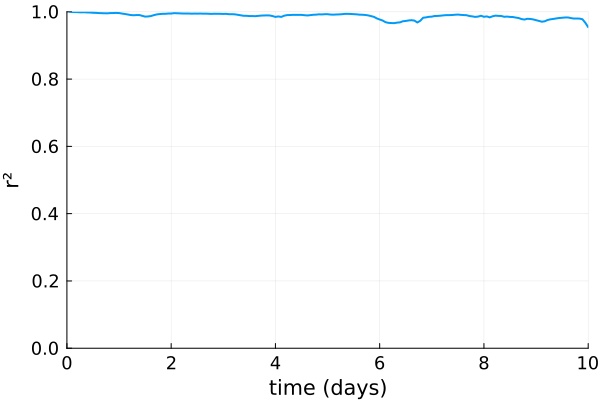

In [61]:
## Plot the r2 throughout the timesteps

begin
    r2 = zeros(Float32, nstep)
    for i in 1:nstep
        r2[i] = Statistics.cor(A[:,1,i], scalar1_GEOS_Array[:,i])^2
    end
    plot(Int(2880/nstep)*10/2880:Int(2880/nstep)*10/2880:10, r2, width=2, label=false, xlabel="time (days)", ylabel="r²", xlabelfontsize=14, ylabelfontsize=14,
        xtickfontsize=12, ytickfontsize=12, xlims=(0,10), ylims=(0.0,1.0))
end
savefig("r2_8x16t.png")

In [216]:
## Calculating correlations in different time steps

Statistics.cor(A[:,1,1], 1e-7*input_NN_integrate[:,1,1,1])^2, Statistics.cor(A[:,1,960], 1e-7*input_NN_integrate[:,1,1,960])^2, Statistics.cor(A[:,1,1920], 1e-7*input_NN_integrate[:,1,1,1920])^2, Statistics.cor(A[:,1,2879], 1e-7*input_NN_integrate[:,1,1,2879])^2

(1.0, 0.9929091138891484, 0.9542317626641522, 0.961742977718)

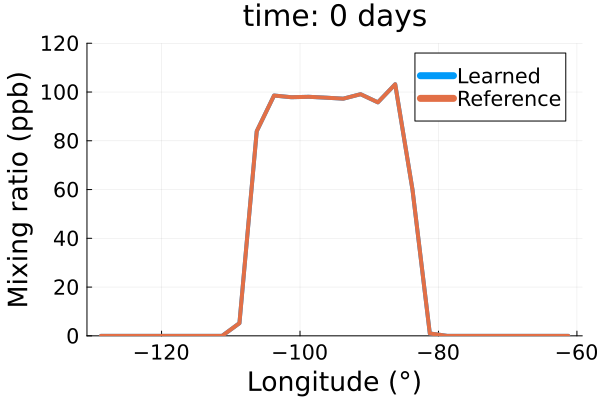

In [41]:
## Example of 1-D visualization with 8dx, 16dt case (t = 0 day). 
## You need to change the dimension if the resolution changes.

begin
    plot(-130.0+0.3125*4:0.3125*8:-60-0.3125*4, A[:,1,1]*1e9, label = "Learned", title = string("time: ", string(0), " days"), 
        xlabel="Longitude (°)", ylabel="Mixing ratio (ppb)", xlabelfontsize=18, ylabelfontsize=18, 
        xtickfontsize=14, ytickfontsize=14, titlefontsize=20, legendfontsize=14, width=4, ylims=(0.0, 1.2e2), legend = true,
         margin=2.5Plots.mm)
    plot!(-130.0+0.3125*4:0.3125*8:-60-0.3125*4, 1e2*input_NN_integrate[:,1,1,1], label = "Reference", width=4)
end

#savefig("8x16t_0day.png")

In [51]:
## Example of 1-D visualization with 8dx, 16dt case (t = 10 days). 
## You need to change the dimension if the resolution changes.

begin
    plot(-130.0+0.3125*4:0.3125*8:-60-0.3125*4, 1e9*A[:,1,179], label = "Learned", title = string("time: ", string(10), " days"), 
        xtickfontsize=14, ytickfontsize=14, titlefontsize=20, width=4, ylims=(0.0, 1.2e2), legend = false, margin=2.5Plots.mm)
    plot!(-130.0+0.3125*4:0.3125*8:-60-0.3125*4, 1e2*input_NN_integrate[:,1,1,179], label = "Reference", width=4)
end

#savefig("8x16t_10day.png")

"/projects/ctessum/manhop2/advect_NN_corrected/8x16t_10day.png"

In [225]:
## Example of 1-D visualization with 1dx, 1dt case (4 panels within 10 days - 0, 3.3, 6.6, and 10 days). 
## You need to change the dimension if the resolution changes.

begin
    xtf=12
    ytf=12
    p1=plot(-130.0+0.3125/2:0.3125*1:-60, 1e9*A[:,1,1], label = "Learned", xticks=[-120, -100, -80, -60], yticks=3,
        xtickfontsize=xtf, ytickfontsize=ytf, width=4, xlims=(-130, -60), ylims=(0.0, 1.4e2), legend = false)
    plot!(-130.0+0.3125/2:0.3125*1:-60, 1e2*input_NN_integrate[:,1,1,1], label = "Reference", width=4)
    p2=plot(-130.0+0.3125/2:0.3125*1:-60, 1e9*A[:,1,960], label = "Learned", xticks=[-120, -100, -80, -60], yticks=3,
        xtickfontsize=xtf, ytickfontsize=ytf, width=4, xlims=(-130, -60), ylims=(0.0, 1.4e2), legend = false)
    plot!(-130.0+0.3125/2:0.3125*1:-60, 1e2*input_NN_integrate[:,1,1,960], label = "Reference", width=4)
    p3=plot(-130.0+0.3125/2:0.3125*1:-60, 1e9*A[:,1,1920], label = "Learned", xticks=[-120, -100, -80, -60], yticks=3,
        xtickfontsize=xtf, ytickfontsize=ytf, width=4, xlims=(-130, -60), ylims=(0.0, 1.4e2), legend = false)
    plot!(-130.0+0.3125/2:0.3125*1:-60, 1e2*input_NN_integrate[:,1,1,1920], label = "Reference", width=4)
    p4=plot(-130.0+0.3125/2:0.3125*1:-60, 1e9*A[:,1,2879], label = "Learned", xticks=[-120, -100, -80, -60], yticks=3,
        xtickfontsize=xtf, ytickfontsize=ytf, width=4, xlims=(-130, -60), ylims=(0.0, 1.4e2), legend = false)
    plot!(-130.0+0.3125/2:0.3125*1:-60, 1e2*input_NN_integrate[:,1,1,2879], label = "Reference", width=4)
    
    plot(p1,p2,p3,p4, layout = (1,4), size=(1200, 200), bottommargin=5Plots.mm, rightmargin=2.5Plots.mm)
end

#savefig("1x1t_time_series.png")

"/projects/ctessum/manhop2/advect_NN_corrected/1x1t_time_series.png"

In [16]:
## Example of 1-D visualization with 8dx, 16dt case (4 panels within 10 days - 0, 3.3, 6.6, and 10 days). 
## You need to change the dimension if the resolution changes.

begin
    xtf=12
    ytf=12
    p1=plot(-130.0+0.3125*4:0.3125*8:-60, 1e9*A_8x16x[:,1,1], label = "Learned", xticks=[-120, -100, -80, -60], yticks=4,
        xtickfontsize=xtf, ytickfontsize=ytf, width=4, xlims=(-130, -60), ylims=(0.0, 1.1e2), legend = false)
    plot!(-130.0+0.3125*4:0.3125*8:-60, 1e2*input_NN_integrate[:,1,1,1], label = "Reference", width=4)
    p2=plot(-130.0+0.3125*4:0.3125*8:-60, 1e9*A_8x16x[:,1,60], label = "Learned", xticks=[-120, -100, -80, -60], yticks=4,
        xtickfontsize=xtf, ytickfontsize=ytf, width=4, xlims=(-130, -60), ylims=(0.0, 1.1e2), legend = false)
    plot!(-130.0+0.3125*4:0.3125*8:-60, 1e2*input_NN_integrate[:,1,1,60], label = "Reference", width=4)
    p3=plot(-130.0+0.3125*4:0.3125*8:-60, 1e9*A_8x16x[:,1,120], label = "Learned", xticks=[-120, -100, -80, -60], yticks=4,
        xtickfontsize=xtf, ytickfontsize=ytf, width=4, xlims=(-130, -60), ylims=(0.0, 1.1e2), legend = false)
    plot!(-130.0+0.3125*4:0.3125*8:-60, 1e2*input_NN_integrate[:,1,1,120], label = "Reference", width=4)
    p4=plot(-130.0+0.3125*4:0.3125*8:-60, 1e9*A_8x16x[:,1,179], label = "Learned", xticks=[-120, -100, -80, -60], yticks=4,
        xtickfontsize=xtf, ytickfontsize=ytf, width=4, xlims=(-130, -60), ylims=(0.0, 1.1e2), legend = false)
    plot!(-130.0+0.3125*4:0.3125*8:-60, 1e2*input_NN_integrate[:,1,1,179], label = "Reference", width=4)
    
    plot(p1,p2,p3,p4, layout = (1,4), size=(1200, 200), bottommargin=5Plots.mm, rightmargin=2.5Plots.mm)
end

savefig("8x16t_time_series.pdf")

LoadError: BoundsError: attempt to access 14×1×1×44 Array{Float32, 4} at index [1:14, 1, 1, 60]

In [19]:
## Example of 1-D visualization with 16dx, 64dt case (4 panels within 10 days - 0, 3.3, 6.6, and 10 days). 
## You need to change the dimension if the resolution changes.

begin
    xtf=12
    ytf=12
    p1=plot(-130.0+0.3125*8:0.3125*16:-60, 1e9*A_16x64x[:,1,1], label = "Learned", xticks=[-120, -100, -80, -60], yticks=4,
        xtickfontsize=xtf, ytickfontsize=ytf, width=4, xlims=(-130, -60), ylims=(0.0, 1.1e2), legend = false)
    plot!(-130.0+0.3125*8:0.3125*16:-60, 1e2*input_NN_integrate[:,1,1,1], label = "Reference", width=4)
    p2=plot(-130.0+0.3125*8:0.3125*16:-60, 1e9*A_16x64x[:,1,15], label = "Learned", xticks=[-120, -100, -80, -60], yticks=4,
        xtickfontsize=xtf, ytickfontsize=ytf, width=4, xlims=(-130, -60), ylims=(0.0, 1.1e2), legend = false)
    plot!(-130.0+0.3125*8:0.3125*16:-60, 1e2*input_NN_integrate[:,1,1,15], label = "Reference", width=4)
    p3=plot(-130.0+0.3125*8:0.3125*16:-60, 1e9*A_16x64x[:,1,30], label = "Learned", xticks=[-120, -100, -80, -60], yticks=4,
        xtickfontsize=xtf, ytickfontsize=ytf, width=4, xlims=(-130, -60), ylims=(0.0, 1.1e2), legend = false)
    plot!(-130.0+0.3125*8:0.3125*16:-60, 1e2*input_NN_integrate[:,1,1,30], label = "Reference", width=4)
    p4=plot(-130.0+0.3125*8:0.3125*16:-60, 1e9*A_16x64x[:,1,44], label = "Learned", xticks=[-120, -100, -80, -60], yticks=4,
        xtickfontsize=xtf, ytickfontsize=ytf, width=4, xlims=(-130, -60), ylims=(0.0, 1.1e2), legend = false)
    plot!(-130.0+0.3125*8:0.3125*16:-60, 1e2*input_NN_integrate[:,1,1,44], label = "Reference", width=4)
    
    plot(p1,p2,p3,p4, layout = (1,4), size=(1200, 200), bottommargin=5Plots.mm, rightmargin=2.5Plots.mm)
end

savefig("16x64t_time_series.pdf")

"/projects/ctessum/manhop2/advect_NN_corrected/16x64t_time_series.pdf"